# üß™ Credit Card Fraud Detection Project

In [1]:
# Standard Libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & Modeling
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, precisionÔºøscore

# Imbalanced Techniques
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN
from imblearn.pipeline import make_pipeline as imb_make_pipeline

# Anomaly Detection
from sklearn.ensemble import IsolationForest

# Dimensionality Reduction
from sklearn.manifold import TSNE

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import zipfile
import pandas as pd

# Path to your zip file
zip_path = 'archive.zip'

# Unzip and read the CSV inside
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # List contents to confirm the file name inside
    print(zip_ref.namelist())
    
    # Read zip file and load into Dataframe
    with zip_ref.open('creditcard.csv') as file:
        df = pd.read_csv(file)

# Preview the data
df.head()

['creditcard.csv']


Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

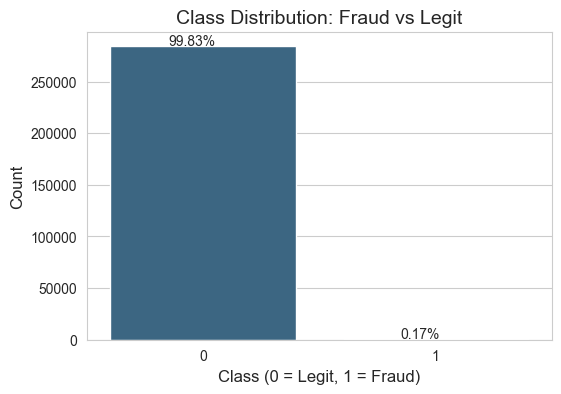

Check for Null Values to address: 
--------------------------------------------------


0

In [3]:
# Overview
df.info()
df.describe()

# Class Distribution
plt.figure(figsize=(6, 4))
sns.set_style("whitegrid")
sns.countplot(x='Class', data=df, hue='Class', palette='viridis', legend=False)
plt.title('Class Distribution: Fraud vs Legit', fontsize=14)
plt.xlabel('Class (0 = Legit, 1 = Fraud)', fontsize=12)
plt.ylabel('Count', fontsize=12)
# Show percentage labels
total = len(df)
for p in plt.gca().patches:
    percentage = '{:.2f}%'.format(100 * p.get_height() / total)
    plt.gca().annotate(percentage, (p.get_x() + 0.25, p.get_height() + 500))

plt.show()

# Check for missing values
print("Check for Null Values to address: \n" + "-" * 50)
df.isnull().sum().max()

**NOTE:**

It is important to realize the `imbalance` in our dataset. Legitamate transactions severly outnumber the fraudulent ones staggeringly! If the dataset is used as-is for our predivtive model then the analysis will overfit and assume that most transactions are not fraud and perform well regardless. We want it to generalize and perform effectively to new data!

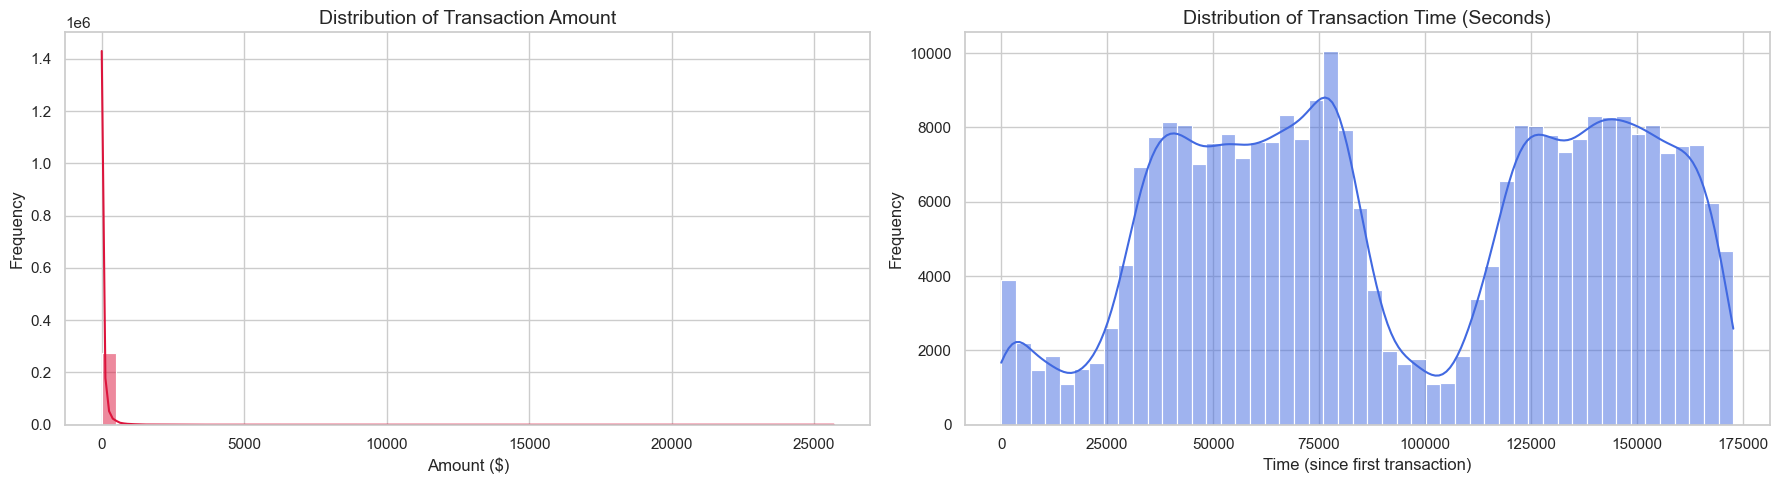

In [4]:
# Optional: Set a consistent style
sns.set(style="whitegrid")

# Compute min/max safely
amount_val = df['Amount'].values
time_val = df['Time'].values

fig, ax = plt.subplots(1, 2, figsize=(18, 5))

# Plot Amount Distribution
sns.histplot(amount_val, bins=50, kde=True, color='crimson', ax=ax[0])
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlabel('Amount ($)', fontsize=12)
ax[0].set_ylabel('Frequency', fontsize=12)
ax[0].grid(True)

# Optional: Log scale
# ax[0].set_xscale('log')

# Plot Time Distribution
sns.histplot(time_val, bins=50, kde=True, color='royalblue', ax=ax[1])
ax[1].set_title('Distribution of Transaction Time (Seconds)', fontsize=14)
ax[1].set_xlabel('Time (since first transaction)', fontsize=12)
ax[1].set_ylabel('Frequency', fontsize=12)
ax[1].grid(True)

plt.tight_layout()
plt.show()

## Scaling and Distribution
---
The next goal is to scale the columns `time` and `amount` as the other columns are already scaled with PCA. To address the imbalance there also needs to be a sub-sample of the dataset made to have equal amount of `Fraud` and `Not Fraud` cases. This will help our model better understand patterns to effectively classify fraudulent transactions.

**Sub-Sampling:**
Sub-sampling is to create a dataframe of equal parts of each class of our target feature. In this case it will be a 50/50 ratio of Fraud and Not Fraud transactions.

**Why Sub-Sample?:**
- Overfitting: Our classifciation model will assume that most cases are not fraud as it will generate a 99.83% accuracy by just doing so with our current dataset! This is not helpful when encountering new data.
- Wrong Correlations: imbalance in a dataset leads to not being able to see true correlations between each class and different features.

**Summary:**
- Scale `amount` and `time` features.
- Create `sub-sample` with **492** cases of fraud and a random **492** cases of not fraud cases in our new dataset.

In [6]:
# Convert scaled arrays back to DataFrames for easier inspection
sc_df = pd.DataFrame(sc, columns=['Amount', 'Time'])
rb_df = pd.DataFrame(rb, columns=['Amount', 'Time'])

# Summary statistics comparison
print("StandardScaler Summary:\n", sc_df.describe(), "\n")
print("RobustScaler Summary:\n", rb_df.describe())

StandardScaler Summary:
              Amount          Time
count  2.848070e+05  2.848070e+05
mean   2.913952e-17 -3.065637e-16
std    1.000002e+00  1.000002e+00
min   -3.532294e-01 -1.996583e+00
25%   -3.308401e-01 -8.552120e-01
50%   -2.652715e-01 -2.131453e-01
75%   -4.471707e-02  9.372174e-01
max    1.023622e+02  1.642058e+00 

RobustScaler Summary:
               Amount           Time
count  284807.000000  284807.000000
mean        0.927124       0.118914
std         3.495006       0.557903
min        -0.307413      -0.994983
25%        -0.229162      -0.358210
50%         0.000000       0.000000
75%         0.770838       0.641790
max       358.683155       1.035022


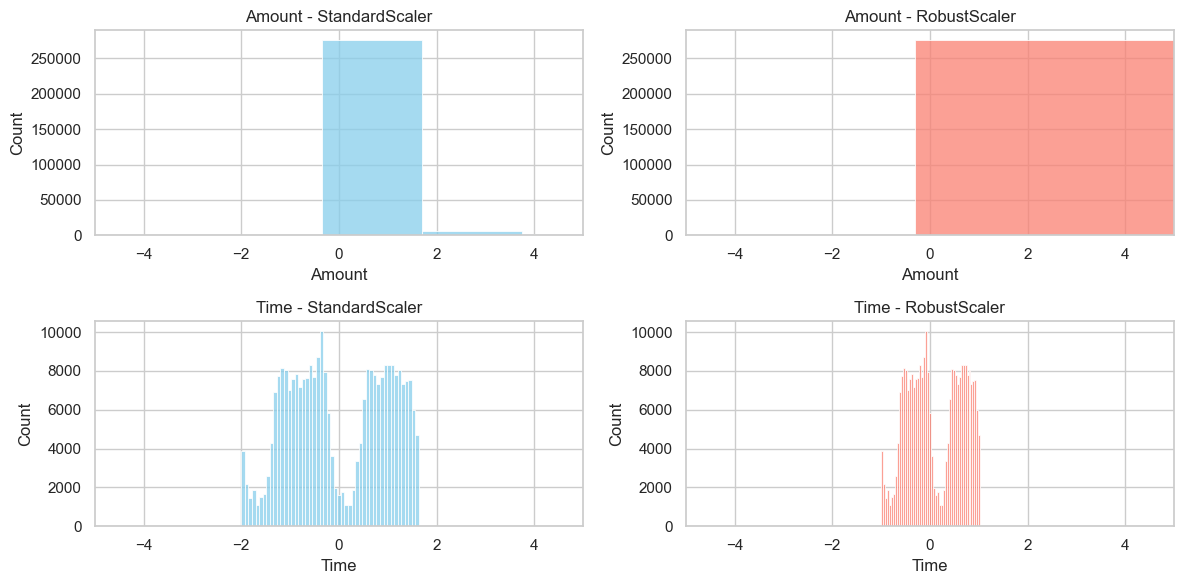

In [7]:
# Test Standard Scaler and Robust Scaler for implementation
sc = StandardScaler().fit_transform(df[['Amount', 'Time']])
rb = RobustScaler().fit_transform(df[['Amount', 'Time']])

fig, ax = plt.subplots(2, 2, figsize=(12, 6))

sns.histplot(sc_df['Amount'], bins=50, ax=ax[0][0], color='skyblue')
ax[0][0].set_title('Amount - StandardScaler')
ax[0][0].set_xlim(-5, 5)

sns.histplot(rb_df['Amount'], bins=50, ax=ax[0][1], color='salmon')
ax[0][1].set_title('Amount - RobustScaler')
ax[0][1].set_xlim(-5, 5)

sns.histplot(sc_df['Time'], bins=50, ax=ax[1][0], color='skyblue')
ax[1][0].set_title('Time - StandardScaler')
ax[1][0].set_xlim(-5, 5)

sns.histplot(rb_df['Time'], bins=50, ax=ax[1][1], color='salmon')
ax[1][1].set_title('Time - RobustScaler')
ax[1][1].set_xlim(-5, 5)

plt.tight_layout()
plt.show()

In [8]:
rb = RobustScaler()

df['scaled_amount'] = rb.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rb.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time', 'Amount'], axis=1, inplace=True)

df.head()

V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       V22       V23       V24       V25  \
0  0.098698  0.363787  0.090794  ...  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425 -0.166974  ... -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  0.207643  ...  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024 -0.054952  ...  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  0.753074  ...  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Class  scaled_amount  scaled_time  
0 -0.189115  0.133558 -0.021053      0       1.783274    -0.994983  
1  0.125895 -0.008983  0.014724      0      -0.269825    -0.994983  
2 -0.139097 -0.055353 -0.059752      0       4.983721    -0.994972  
3 -0.221929  0.062723  0.061458      0       1.418291    -0.994972  
4  0.502292  0.219422  0.215153      0       0.670579    -0.994960  

[5 rows x 31 columns]

**Note:**
Here we will got with Robust Scaler as it better deals with outliers and evens out our IQR for a more even distribution.

### Splitting the Data:
Before performing randomized UnderSampling and OverSampling we have to separate the original dataset because we want to test our models on the original testing set. We will use StratifiedKFold to maintain class balance which is crucial in **highly imbalanced** datasets. Regular KFold can result in folds with **no fraud samples** (BAD!).

In [11]:
# Separate features and labels
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, t_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Shuffle=True for balanced and realistic folds

# Train-test split
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train_fold = X.iloc[train_idx]
    y_train_fold = y.iloc[train_idx]
    X_val_fold = X.iloc[test_idx]
    y_val_fold = y.iloc[test_idx]



### Random Under-Sampling:

In [12]:
# Random Undersampling
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

# Random Oversampling
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

# SMOTEEN
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

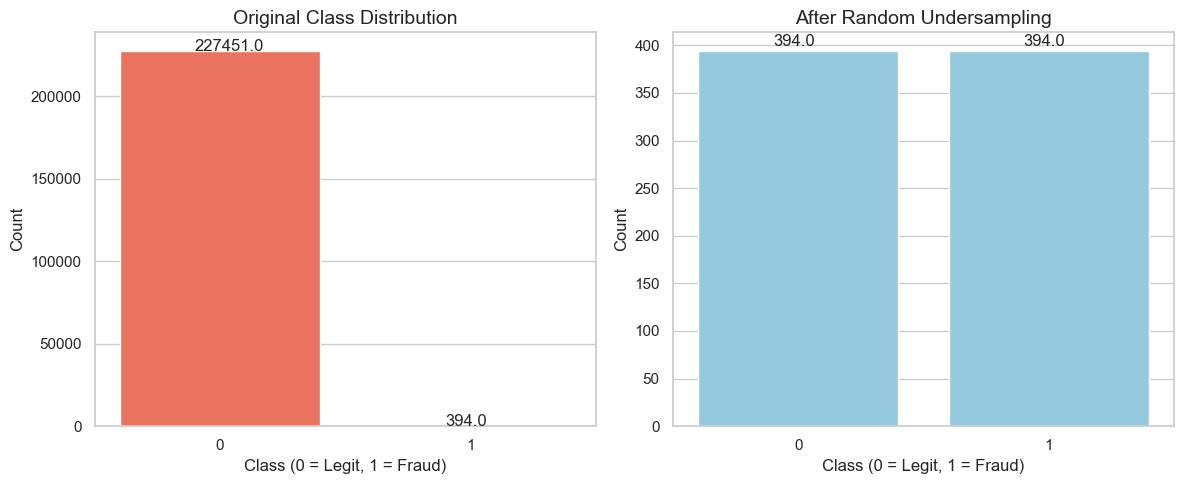

In [13]:
# Convert original and undersampled y into DataFrames for plotting
y_train_df = pd.DataFrame(y_train, columns=['Class'])
y_rus_df = pd.DataFrame(y_rus, columns=['Class'])

# Set style
sns.set_style("whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before undersampling
sns.countplot(data=y_train_df, x='Class', ax=axes[0], color='salmon')
axes[0].set_title('Original Class Distribution', fontsize=14)
axes[0].set_xlabel('Class (0 = Legit, 1 = Fraud)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)

# Add counts
for p in axes[0].patches:
    axes[0].annotate(p.get_height(), (p.get_x() + 0.3, p.get_height() + 5), fontsize=12)

# After undersampling
sns.countplot(data=y_rus_df, x='Class', ax=axes[1], color='skyblue')
axes[1].set_title('After Random Undersampling', fontsize=14)
axes[1].set_xlabel('Class (0 = Legit, 1 = Fraud)', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)

# Add counts
for p in axes[1].patches:
    axes[1].annotate(p.get_height(), (p.get_x() + 0.3, p.get_height() + 5), fontsize=12)

plt.tight_layout()
plt.show()

## Correlation Matrix (Heat Map)
We want to know what features are heavily influcing whether a specific transaction will be classified as fraud or not. We will make this correlation matrix from our sub-sample.

- `Negative` Values: `V17, V14, V12, and V10` are negatively correlated which will likely influence its classification as a **fraud transaction**.
- `Positive` Values: `V19, V11, V4, V2` are positively correlated which will likely influece its classification as a **fraud transaction**.

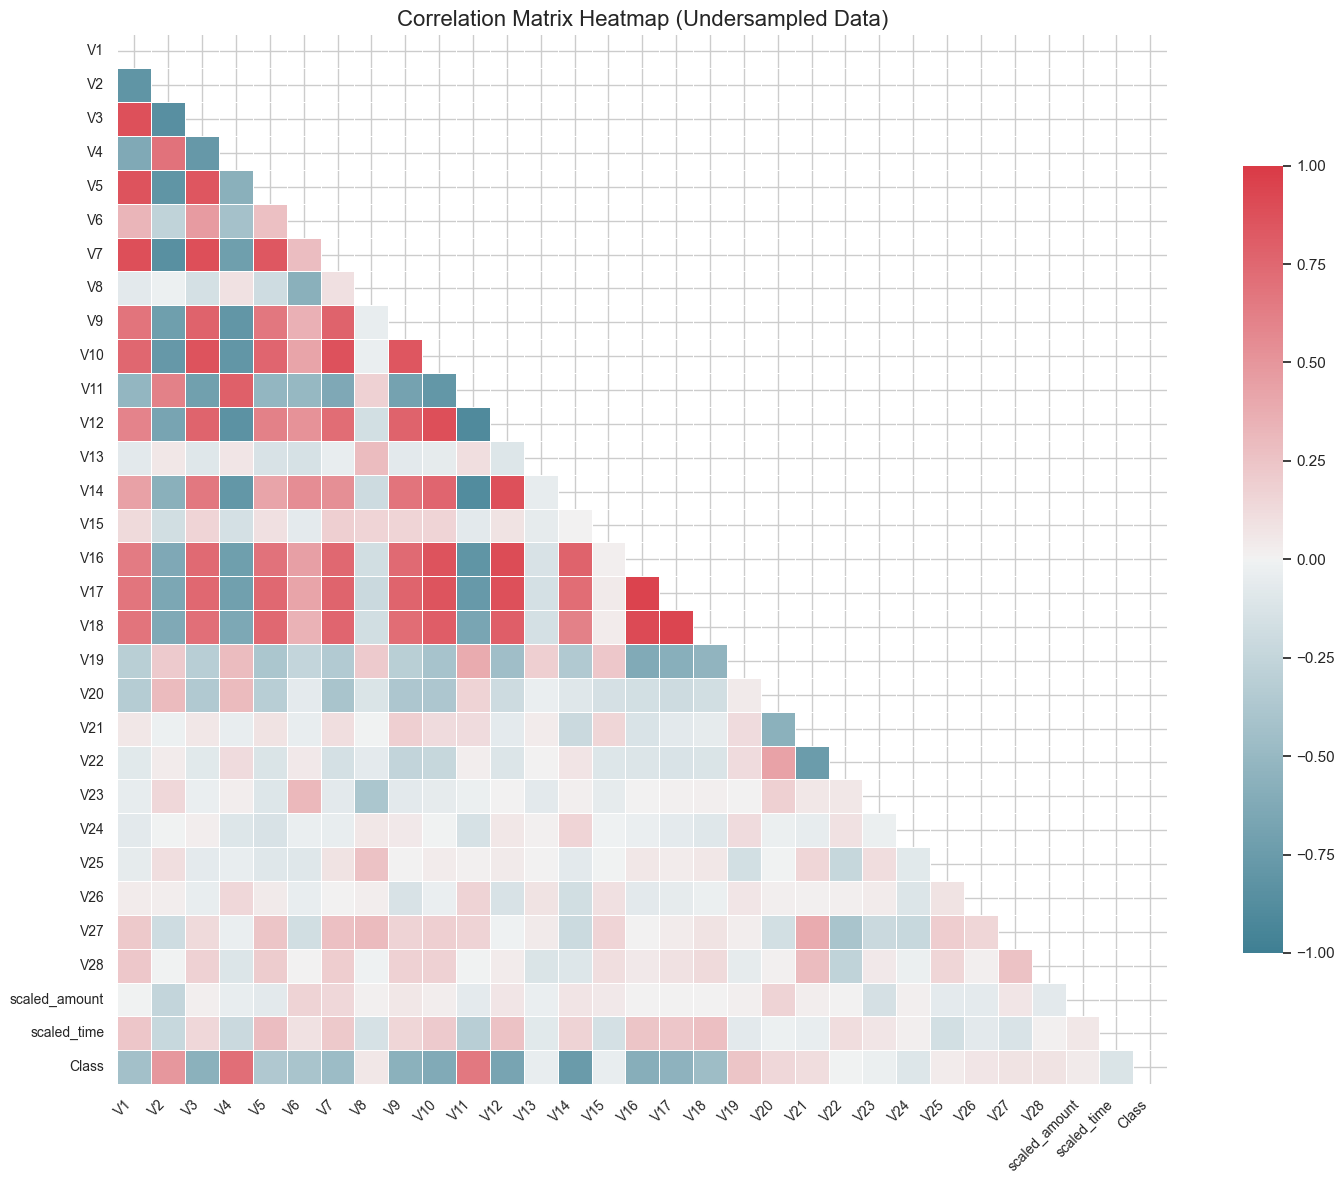

In [14]:
# Combine X_rus and y_rus into a DataFrame for correlation analysis
X_rus_df = pd.DataFrame(X_rus, columns=X_train.columns)
y_rus_df = pd.DataFrame(y_rus, columns=['Class'])
subsample_df = pd.concat([X_rus_df, y_rus_df], axis=1)

# Compute the correlation matrix
corr_matrix = subsample_df.corr()

# Set the figure size
plt.figure(figsize=(16, 12))

# Generate a mask for the upper triangle (for cleaner look)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the color palette
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Create the heatmap
sns.heatmap(corr_matrix, 
            mask=mask,
            cmap=cmap, 
            vmax=1.0, 
            vmin=-1.0,
            center=0,
            annot=False,
            square=True, 
            linewidths=0.5, 
            cbar_kws={"shrink": 0.75},
            xticklabels=True,
            yticklabels=True)

# Title and layout
plt.title('Correlation Matrix Heatmap (Undersampled Data)', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

## Outliers

Identify outliers by using a marker so that we do not lose valuable information. We do not want data loss as our minority class already has very low observations comparatively.

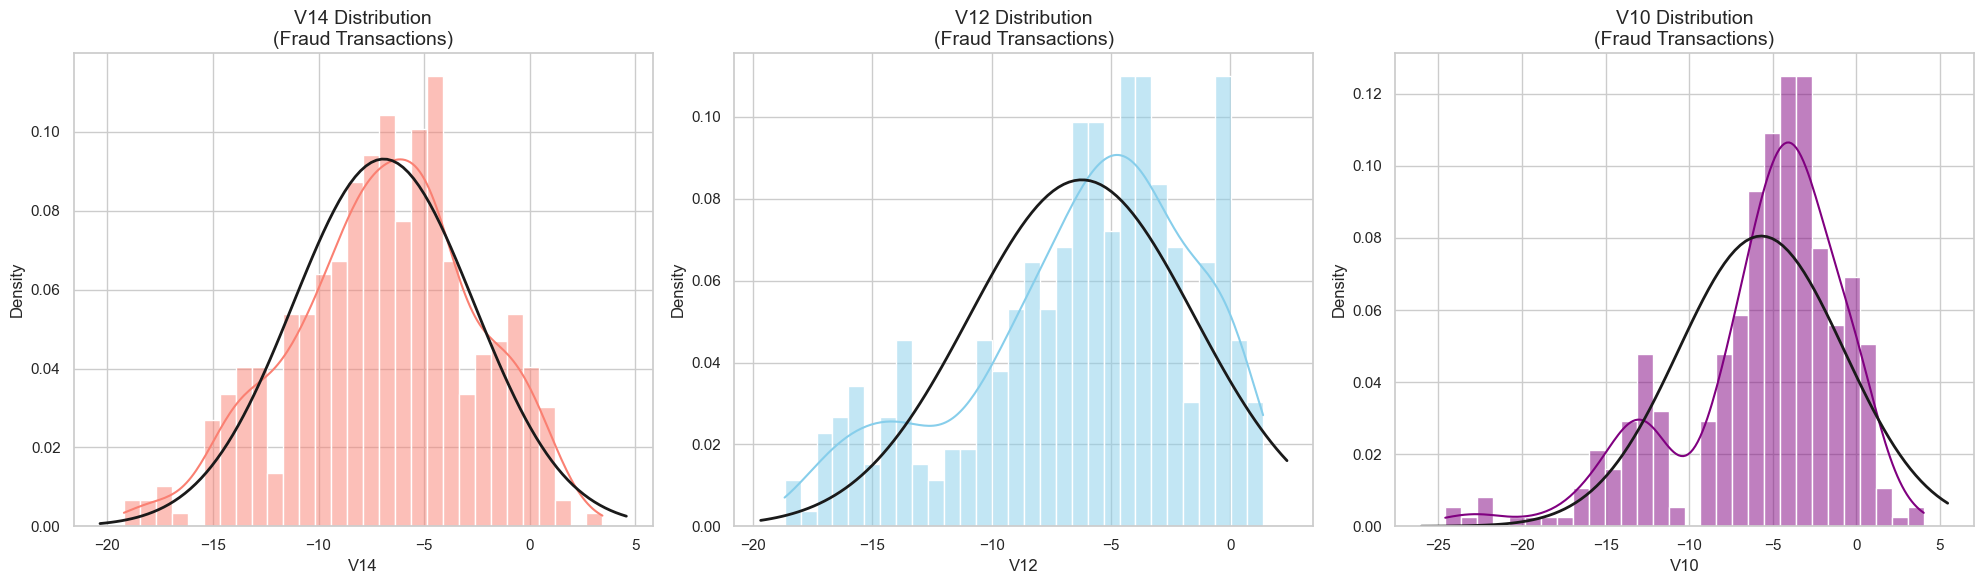

In [19]:
from scipy.stats import norm

# Filter just the fraud transactions
fraud_df = subsample_df[subsample_df['Class'] == 1]

# Set up subplots
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
sns.set_style("whitegrid")

# V14 Distribution
sns.histplot(fraud_df['V14'], ax=ax1, kde=True, stat="density", color='salmon', bins=30)
x = fraud_df['V14']
mu, std = norm.fit(x)
xmin, xmax = ax1.get_xlim()
x_vals = np.linspace(xmin, xmax, 100)
p = norm.pdf(x_vals, mu, std)
ax1.plot(x_vals, p, 'k', linewidth=2)
ax1.set_title('V14 Distribution\n(Fraud Transactions)', fontsize=14)

# V12 Distribution
sns.histplot(fraud_df['V12'], ax=ax2, kde=True, stat="density", color='skyblue', bins=30)
x = fraud_df['V12']
mu, std = norm.fit(x)
xmin, xmax = ax2.get_xlim()
x_vals = np.linspace(xmin, xmax, 100)
p = norm.pdf(x_vals, mu, std)
ax2.plot(x_vals, p, 'k', linewidth=2)
ax2.set_title('V12 Distribution\n(Fraud Transactions)', fontsize=14)

# V10 Distribution
sns.histplot(fraud_df['V10'], ax=ax3, kde=True, stat="density", color='purple', bins=30)
x = fraud_df['V10']
mu, std = norm.fit(x)
xmin, xmax = ax3.get_xlim()
x_vals = np.linspace(xmin, xmax, 100)
p = norm.pdf(x_vals, mu, std)
ax3.plot(x_vals, p, 'k', linewidth=2)
ax3.set_title('V10 Distribution\n(Fraud Transactions)', fontsize=14)

plt.tight_layout()
plt.show()

In [26]:
def remove_outliers_iqr(df, feature, class_col='Class', target_class=1, iqr_factor=1.5):
    target_data = df[df[class_col] == target_class][feature]
    q25, q75 = np.percentile(target_data, 25), np.percentile(target_data, 75)
    iqr = q75 - q25
    cut_off = iqr * iqr_factor
    lower, upper = q25 - cut_off, q75 + cut_off
    print(f'{feature} | Lower: {lower:.4f}, Upper: {upper:.4f}')
    print(f'Outliers Removed: {sum((target_data < lower) | (target_data > upper))}')
    
    # Drop rows
    return df.drop(df[(df[feature] < lower) | (df[feature] > upper)].index)

In [28]:
new_df = remove_outliers_iqr(subsample_df, 'V14', iqr_factor=1.5)
new_df = remove_outliers_iqr(subsample_df, 'V12', iqr_factor=1.5)
new_df = remove_outliers_iqr(subsample_df, 'V10', iqr_factor=1.5)

V14 | Lower: -17.7609, Upper: 3.9014
Outliers Removed: 3
V12 | Lower: -17.4636, Upper: 5.9563
Outliers Removed: 4
V10 | Lower: -15.0179, Upper: 5.0094
Outliers Removed: 22


In [ ]:
'''
def add_outlier_flag(df, feature, class_col='Class', target_class=1, iqr_factor=1.5):
    # Apply only to a subset (e.g., fraud cases)
    target_data = df[df[class_col] == target_class][feature]
    q25, q75 = np.percentile(target_data, 25), np.percentile(target_data, 75)
    iqr = q75 - q25
    cut_off = iqr * iqr_factor
    lower, upper = q25 - cut_off, q75 + cut_off
    
    flag_name = f'{feature}_outlier'
    df[flag_name] = ((df[feature] < lower) | (df[feature] > upper)).astype(int)
    
    print(f"‚úÖ Added flag '{flag_name}' | Thresholds: [{lower:.2f}, {upper:.2f}]")
    return df
'''

In [29]:
# Drop target for unsupervised isolation
X_iso = subsample_df.drop(columns=['Class'])

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
iso_forest.fit(X_iso)

# Add anomaly score as a new feature (higher = more normal)
subsample_df['iso_score'] = iso_forest.decision_function(X_iso)

# (Optional) Add binary flag for top anomalies
subsample_df['iso_outlier'] = iso_forest.predict(X_iso)
subsample_df['iso_outlier'] = subsample_df['iso_outlier'].map({1: 0, -1: 1})  # 1 = outlier

# Quick preview
print(subsample_df[['iso_score', 'iso_outlier']].head())

        iso_score  iso_outlier
20945    0.281449            0
159516   0.251714            0
229456   0.261254            0
127881   0.262492            0
158110   0.248321            0


## Dimensionality Reduction

Test `TSNE`, `PCA`, and `TruncatedSVD`

In [32]:
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

# üì¶ Prepare features and labels
X = subsample_df.drop(columns=['Class', 'iso_outlier'])
y = subsample_df['Class']

# üéØ Dimensionality reduction settings
n_components = 2
random_state = 42

# ‚è± T-SNE
start = time.time()
X_tsne = TSNE(n_components=n_components, random_state=random_state).fit_transform(X.values)
end = time.time()
print(f"‚úÖ t-SNE completed in {end - start:.2f} seconds.")

# ‚è± PCA
start = time.time()
X_pca = PCA(n_components=n_components, random_state=random_state).fit_transform(X.values)
end = time.time()
print(f"‚úÖ PCA completed in {end - start:.2f} seconds.")

# ‚è± Truncated SVD (for sparse or linear cases)
start = time.time()
X_svd = TruncatedSVD(n_components=n_components, algorithm='randomized', random_state=random_state).fit_transform(X.values)
end = time.time()
print(f"‚úÖ Truncated SVD completed in {end - start:.2f} seconds.")

‚úÖ t-SNE completed in 1.03 seconds.
‚úÖ PCA completed in 0.01 seconds.
‚úÖ Truncated SVD completed in 0.00 seconds.


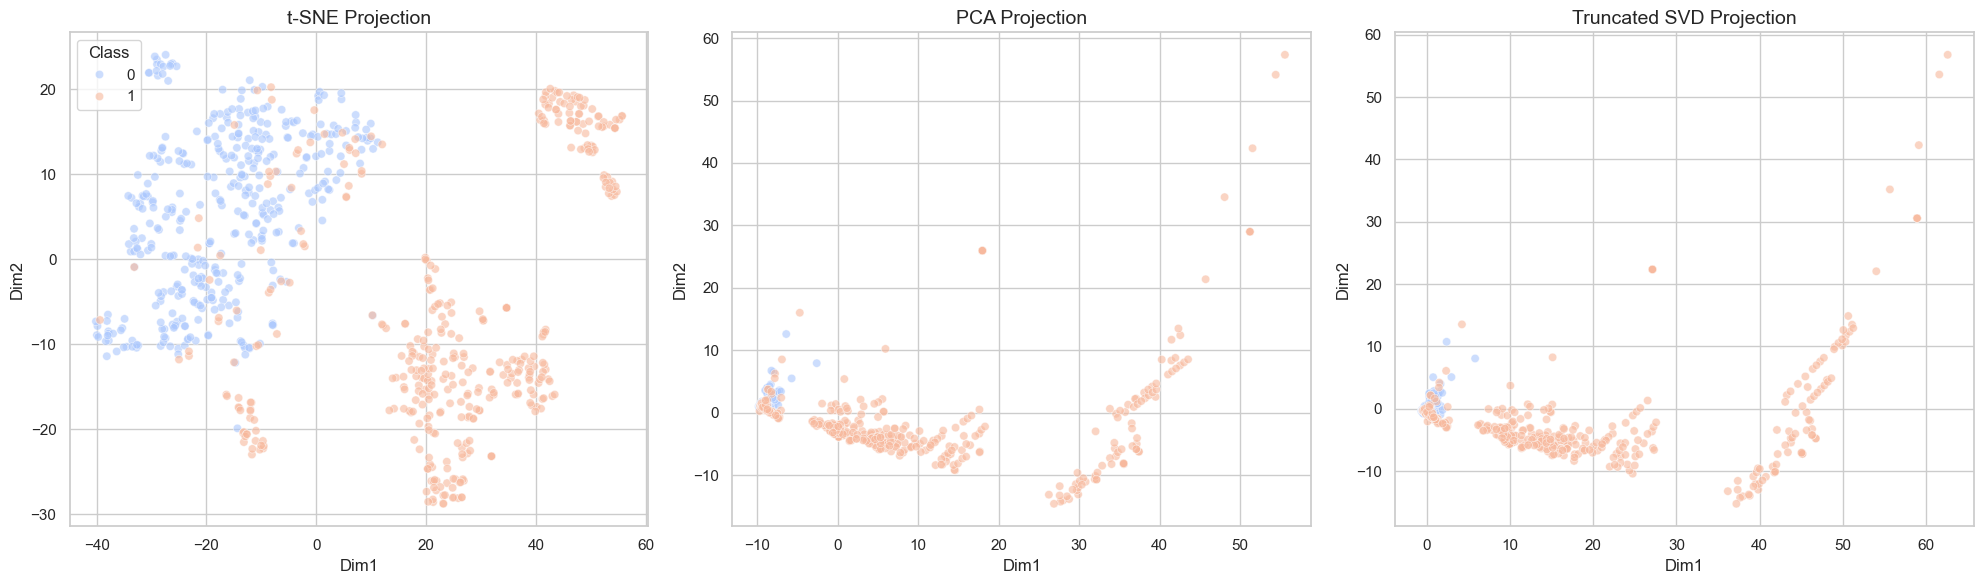

In [33]:
# Create DataFrames for easier plotting
df_tsne = pd.DataFrame(X_tsne, columns=['Dim1', 'Dim2'])
df_pca = pd.DataFrame(X_pca, columns=['Dim1', 'Dim2'])
df_svd = pd.DataFrame(X_svd, columns=['Dim1', 'Dim2'])

# Add labels
df_tsne['Class'] = y.values
df_pca['Class'] = y.values
df_svd['Class'] = y.values

# Plot settings
sns.set(style='whitegrid')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# t-SNE
sns.scatterplot(data=df_tsne, x='Dim1', y='Dim2', hue='Class', palette='coolwarm', ax=ax1, alpha=0.6)
ax1.set_title('t-SNE Projection', fontsize=14)
ax1.legend(title='Class', loc='best')

# PCA
sns.scatterplot(data=df_pca, x='Dim1', y='Dim2', hue='Class', palette='coolwarm', ax=ax2, alpha=0.6)
ax2.set_title('PCA Projection', fontsize=14)
ax2.legend().remove()

# Truncated SVD
sns.scatterplot(data=df_svd, x='Dim1', y='Dim2', hue='Class', palette='coolwarm', ax=ax3, alpha=0.6)
ax3.set_title('Truncated SVD Projection', fontsize=14)
ax3.legend().remove()

plt.tight_layout()
plt.show()

In [34]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier()
}

for name, model in models.items():
    model.fit(X_smote, y_smote)
    preds = model.predict(X_test)
    print(f"\n{name}")
    print(classification_report(y_test, preds))


Logistic Regression
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962


Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.87      0.84      0.85        98

    accuracy                           1.00     56962
   macro avg       0.94      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962


XGBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.72      0.86      0.78        98

    accuracy                           1.00     56962
   macro avg       0.86      0.93      0.89     56962
weighted avg       1.00      

In [ ]:
model = Sequential([
    Dense(64, input_dim=X_smote.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_smote, y_smote, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate on test set
y_pred_nn = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred_nn))

### ‚úÖ Conclusion
- Compare model metrics (F1-score, Precision-Recall, AUC).
- Logistic Regression may give good interpretability, but XGBoost/LightGBM can give better performance.
- Neural Network can capture nonlinear patterns but may need tuning.
- Consider ensembling, feature selection, or model saving for deployment in future iterations.